In [1]:
%load_ext autoreload
%autoreload 2
import os
os.chdir('/home/jorge/thesis')


from text3d2video.artifacts.anim_artifact import AnimationArtifact
from torch import Tensor
import torchvision.transforms.functional as TF
import torch

In [2]:
from PIL import Image

from text3d2video.utilities.ipython_utils import display_vid
from text3d2video.utilities.video_util import pil_frames_to_clip

noises = torch.randn(5, 4, 64, 64)

def noise_imgs(noises: Tensor, res: int=512):

    images = []
    for noise in noises:
        noise_pil = TF.to_pil_image(noise[0:3, :, :].cpu())
        noise_pil = noise_pil.resize((res, res), Image.NEAREST)
        images.append(noise_pil)
    return images

display_vid(pil_frames_to_clip(noise_imgs(noises)))

In [3]:
from text3d2video.noise_initialization import RandomNoiseInitializer
from torch import Generator

device = 'cuda'

gen = Generator(device=device)
gen.manual_seed(0)

random_noise = RandomNoiseInitializer()

noise = random_noise.initial_noise(4, generator=gen, device=device)

display_vid(pil_frames_to_clip(noise_imgs(noise)))

In [4]:
from text3d2video.noise_initialization import FixedNoiseInitializer, RandomNoiseInitializer
from torch import Generator

device = 'cuda'

gen = Generator(device=device)
gen.manual_seed(0)

random_noise = FixedNoiseInitializer()

noise = random_noise.initial_noise(4, generator=gen, device=device)

display_vid(pil_frames_to_clip(noise_imgs(noise)))

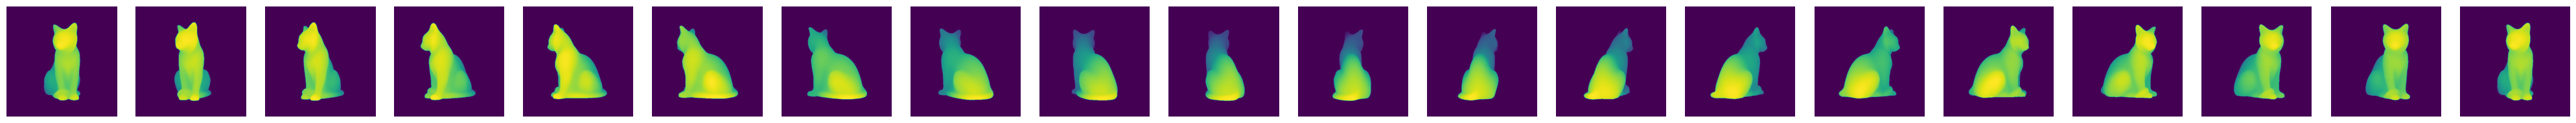

In [7]:
import torch
from pytorch3d.io import load_obj, load_objs_as_meshes

from text3d2video.rendering import render_depth_map
from text3d2video.utilities.camera_placement import (
    turntable_extrinsics,
)
from text3d2video.utilities.ipython_utils import display_ims
from text3d2video.utilities.mesh_processing import normalize_meshes
from pytorch3d.renderer import FoVPerspectiveCameras

mesh_path = "data/meshes/cat_statue.obj"
device = "cuda"

# read mesh
verts, faces, aux = load_obj(mesh_path)
verts_uvs = aux.verts_uvs.to(device)
faces_uvs = faces.textures_idx.to(device)

mesh = load_objs_as_meshes([mesh_path], device=device)
mesh = normalize_meshes(mesh)

n_frames = 20
dist = 3
angles = torch.linspace(0, 360, n_frames)
xs = torch.linspace(-0.5, 0.5, 20)
R, T = turntable_extrinsics(dists=dist, angles=angles)

frame_cams = FoVPerspectiveCameras(R=R, T=T, device="cuda", fov=30)
frame_meshes = mesh.extend(len(frame_cams))

display_ims(render_depth_map(frame_meshes, frame_cams))

In [12]:
from text3d2video.noise_initialization import UVNoiseInitializer


device = "cuda"

gen = Generator(device=device)
gen.manual_seed(0)

random_noise = UVNoiseInitializer(noise_texture_res=70, include_background=True)
random_noise.sample_noise_texture(gen)
random_noise.sample_background(gen)

noise = random_noise.initial_noise(
    frame_meshes, frame_cams, verts_uvs, faces_uvs
)

display_vid(pil_frames_to_clip(noise_imgs(noise)))

In [51]:
noise_init = UVNoiseInitializer()

gen_bg = torch.Generator(device="cuda").manual_seed(1)
gen_tex = torch.Generator(device="cuda").manual_seed(1)

noise_init.sample_background(generator=gen_bg)
noise_init.sample_noise_texture(generator=gen_tex)

noise = noise_init.initial_noise(meshes, cameras, verts_uvs, faces_uvs)

display_vid(pil_frames_to_clip(noise_imgs(noise)))

In [ ]:
uv_noise = noise_init.uv_noise
bg_noise = noise_init.bg_noise

reconstructed = UVNoiseInitializer.init_from_textures(uv_noise, bg_noise)

noise = reconstructed.initial_noise(meshes, cameras, verts_uvs, faces_uvs)
display_vid(pil_frames_to_clip(noise_imgs(noise)))

: 